# Task 03: Photovoltaics

## 3.1 The Sandia PV Performance Modelling Collaborative (PVPMC)

## 3.2 Irradiance & Insolation

1. How do you get the insolation from the irradiance? What are typical units of these two quantities?
- Irradiance is an instantaneous measurement of solar power over some area and Insolation is a measure of the cumulative energy over determined area throughout a certain period of time.
- The units of irradiance are watts per square meter and for irradiance is kilowatt hours per square meter.
2. What are normal irradiance, diffuse horizontal irradiance and global horizontal irradiance and how do you measure it?
- Normal: is the amount of solar radiation received per unit area by a surface that is always held perpendicular (or normal) to the rays that come in a straight line from the direction of the sun at its current position in the sky; Measured through an absolute cavity radiometer or calculated via co-planar measurements of the total and diffuse radiations.
- Diffuse horizontal: is the terrestrial irradiance received by a horizontal surface which has been scattered or diffused by the atmosphere; typically measured with a pyranometer, but on this case the direct light of the sun is blocked in order to remove the beam component of the radiation. If it can't be measured it can be calculated using the known value of the global horizontal irradiance.
- Global horizontal: is the amount of terrestrial irradiance falling on a surface horizontal to the surface of the earth; it is also measured using a pyranometer with a hemispherical view angle. Can be calculated using an equation: $$GHI=DHI+DNI*cos(\theta)$$ where $\theta$ = angle of incidence of the beam.

## 3.3 Install pvlib

1. What does pvlib.location.Location.get_clearsky() do?

The get_clearsky() method calculate the clear sky estimates of GHI, DNI, and/or DHI at this location. It automatically calculates the solar position, extraterrestrial irradiance, airmass, and atmospheric pressure, leaving the user to only specify the 2 parameters: time and atmospheric attenuation.
The time input must be a pandas DatetimeIndex, while the atmospheric attenuation inputs may be constants or arrays.
The get_clearsky() method always returns a pandas DataFrame.

Parameters used by the command:

times (DatetimeIndex) –
model (str, default 'ineichen') – The clear sky model to use. Must be one of ‘ineichen’, ‘haurwitz’, ‘simplified_solis’.
solar_position (None or DataFrame, default None) – DataFrame with columns ‘apparent_zenith’, ‘zenith’, ‘apparent_elevation’.
dni_extra (None or numeric, default None) – If None, will be calculated from times.
kwargs – Extra parameters passed to the relevant functions. Climatological values are assumed in many cases. See source code for details!

Result returned:
clearsky (DataFrame) – Column names are: ghi, dni, dhi.

In [5]:
pvlib.location.Location.get_clearsky()

TypeError: get_clearsky() missing 2 required positional arguments: 'self' and 'times'

The code requires a location (self) and time to fix the TypeError.

In [22]:
import os
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pvlib

from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3

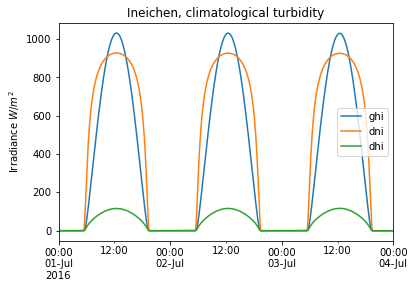

In [23]:
tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')
times = pd.date_range(start='2016-07-01', end='2016-07-04', freq='1min', tz=tus.tz)
cs = tus.get_clearsky(times)  # ineichen with climatology table by default
cs.plot();
plt.ylabel('Irradiance $W/m^2$');
plt.title('Ineichen, climatological turbidity');

## 3.4 Plane of Array (POA) Irradiance

In [24]:
from pvlib import location
from pvlib import irradiance
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import figure

The location used is the Green FabLab in Kamp-Lintfort, Germany, that has the following latitude and longitude (51.499 and 6.548) and the time zone is Middle European Time (MET), also known as Central European Time (CET).

In [25]:
tz = 'MET'
lat, lon = 51.499, 6.548

site = location.Location(lat, lon, tz=tz)

With this data a site can be determined to calculate the clear-sky Global Horizon Irradiance and transpose to a plane of array that allows the code to be re-used for different locations.

The get irradiance command creates a one day's worth of 10 minutes intervals and generates clearsky data using the Inechen model to return a dataframe with values for GHI, DNI and DHI.

clearsky is defined as a variable to get the solar azimuth and zenith to pass to the transposition function and solar position is responsible for the total irradiiance function to transpode the GHI to POA (Plane of Array Irradiance).

These commands return a dataframe with only GHI and POA.

In [26]:
def get_irradiance(site_location, date, tilt, surface_azimuth):
    times = pd.date_range(date, freq='10min', periods=6*24,
                          tz=site_location.tz)
    clearsky = site_location.get_clearsky(times)
    solar_position = site_location.get_solarposition(times=times)
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        dni=clearsky['dni'],
        ghi=clearsky['ghi'],
        dhi=clearsky['dhi'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'])
    return pd.DataFrame({'GHI': clearsky['ghi'],
                         'POA': POA_irradiance['poa_global']})

To gather specific irradiance data regarding the summer and winter solstice and spring equinox, assuming a 60 degree tilt and a southwest facing array, the parameters needed are the location, date, tilt angle and direction angle, on this case, southwest indicates 225 degrees.

In order to make plotting the graphs simpler, the dataframe indexes are converted to a Hour:Minute format.

In [27]:
summer_irradiance = get_irradiance(site, '06-20-2020', 60, 225)
winter_irradiance = get_irradiance(site, '12-21-2020', 60, 225)
spring_irradiance = get_irradiance(site, '03-20-2020', 60, 225)

summer_irradiance.index = summer_irradiance.index.strftime("%H:%M")
winter_irradiance.index = winter_irradiance.index.strftime("%H:%M")
spring_irradiance.index = spring_irradiance.index.strftime("%H:%M")

Afterwards, the process of plotting the graphs defining GHI and POA irradiances to compare them throughout the solstices and spring equinox.

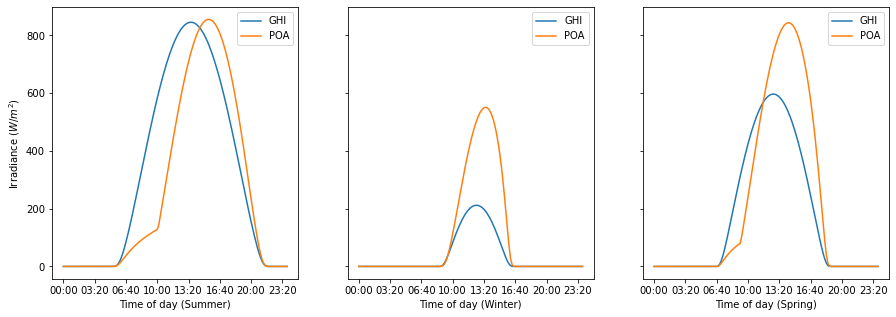

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
summer_irradiance['GHI'].plot(ax=ax1, label='GHI')
summer_irradiance['POA'].plot(ax=ax1, label='POA')
winter_irradiance['GHI'].plot(ax=ax2, label='GHI')
winter_irradiance['POA'].plot(ax=ax2, label='POA')
spring_irradiance['GHI'].plot(ax=ax3, label='GHI')
spring_irradiance['POA'].plot(ax=ax3, label='POA')
ax1.set_xlabel('Time of day (Summer)')
ax2.set_xlabel('Time of day (Winter)')
ax3.set_xlabel('Time of day (Spring)')
ax1.set_ylabel('Irradiance ($W/m^2$)')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

Another option given was tilting the modules 30 degrees instead of 60 degrees, so the procedure is the same, but changing the module angle parameter, this being said, the new data given to the program is the following:

In [29]:
summer_irradiance = get_irradiance(site, '06-20-2020', 30, 225)
winter_irradiance = get_irradiance(site, '12-21-2020', 30, 225)
spring_irradiance = get_irradiance(site, '03-20-2020', 30, 225)

summer_irradiance.index = summer_irradiance.index.strftime("%H:%M")
winter_irradiance.index = winter_irradiance.index.strftime("%H:%M")
spring_irradiance.index = spring_irradiance.index.strftime("%H:%M")

And the new plotting of the graphs result on:

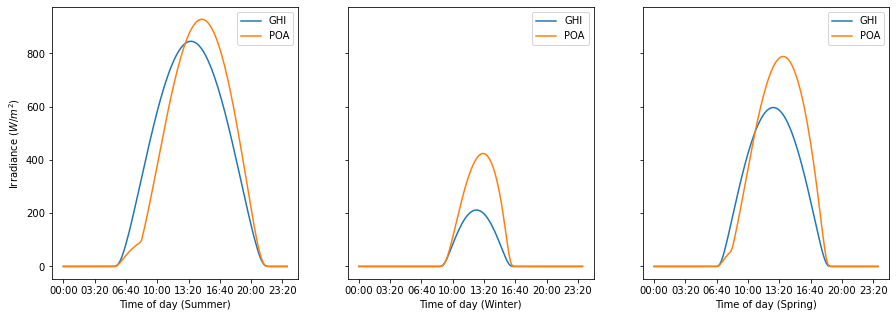

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
summer_irradiance['GHI'].plot(ax=ax1, label='GHI')
summer_irradiance['POA'].plot(ax=ax1, label='POA')
winter_irradiance['GHI'].plot(ax=ax2, label='GHI')
winter_irradiance['POA'].plot(ax=ax2, label='POA')
spring_irradiance['GHI'].plot(ax=ax3, label='GHI')
spring_irradiance['POA'].plot(ax=ax3, label='POA')
ax1.set_xlabel('Time of day (Summer)')
ax2.set_xlabel('Time of day (Winter)')
ax3.set_xlabel('Time of day (Spring)')
ax1.set_ylabel('Irradiance ($W/m^2$)')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

Comparing the 60 degrees inclination of the module with the 30 degrees on the 3 given dates the results were similar, but with some specific changes due to the solar angle.

During the summer solstice, the second inclination returned a higher reading of the GHI, meanwhile both POA readings were similar;

On the winter solstice the GHI reading stayed inaltered while the POA reading was considerably smaller.

A similar result, but with a smaller rate, happened during the spring equinox. The GHI remained almost constant, but the POA reading returned smaller than on the first case.

## 3.5 Plot the sun paths for Kamp-Lintfort

1. Cartesian and Polar coordinates

- Cartesian coordinates

In [31]:
from pvlib import solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The timezone used is the UTC, with latitude and longitude from the Kamp-Lintfort location and considering the year 2021.

With the data defined above the position is set and the solar position can be calculated, removing nighttime.

In [32]:
tz = 'UTC'
lat, lon = 51.499, 6.548
times = pd.date_range('2020-01-01 00:00:00', '2021-01-01', closed='left',
                      freq='H', tz=tz)

solpos = solarposition.get_solarposition(times, lat, lon)

solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

To create the graph showing cartesian coordinates the following step is to subplot the figure.

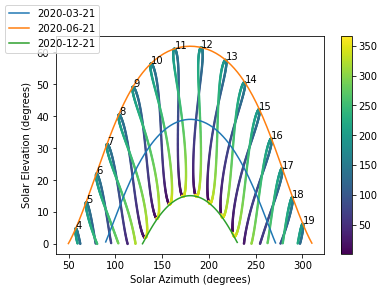

In [33]:
fig, ax = plt.subplots()
points = ax.scatter(solpos.azimuth, solpos.apparent_elevation, s=2,
                    c=solpos.index.dayofyear, label=None)
fig.colorbar(points)

for hour in np.unique(solpos.index.hour):
    # choose label position by the largest elevation for each hour
    subset = solpos.loc[solpos.index.hour == hour, :]
    height = subset.apparent_elevation
    pos = solpos.loc[height.idxmax(), :]
    ax.text(pos['azimuth'], pos['apparent_elevation'], str(hour))

for date in pd.to_datetime(['2020-03-21', '2020-06-21', '2020-12-21']):
    times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5min', tz=tz)
    solpos = solarposition.get_solarposition(times, lat, lon)
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    label = date.strftime('%Y-%m-%d')
    ax.plot(solpos.azimuth, solpos.apparent_elevation, label=label)

ax.figure.legend(loc='upper left')
ax.set_xlabel('Solar Azimuth (degrees)')
ax.set_ylabel('Solar Elevation (degrees)')

plt.show()

- Polar coordinates

In [34]:
import os
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pvlib

from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3

from pvlib import solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

Same position, timezone, time frame and solar position definition.

In [35]:
tz = 'UTC'
lat, lon = 51.499, 6.548

times = pd.date_range('2020-01-01 00:00:00', '2021-01-01', closed='left',
                      freq='H', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)

solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

The next step is to draw the analemma loops, the hour labels and the individual days. After these steps the polar coordinates are specified, like a compass and the new graph is plotted.

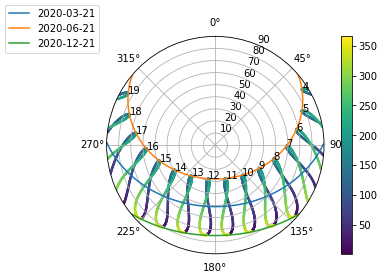

In [36]:
ax = plt.subplot(1, 1, 1, projection='polar')

points = ax.scatter(np.radians(solpos.azimuth), solpos.apparent_zenith,
                    s=2, label=None, c=solpos.index.dayofyear)
ax.figure.colorbar(points)

for hour in np.unique(solpos.index.hour):
    # choose label position by the smallest radius for each hour
    subset = solpos.loc[solpos.index.hour == hour, :]
    r = subset.apparent_zenith
    pos = solpos.loc[r.idxmin(), :]
    ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))

for date in pd.to_datetime(['2020-03-21', '2020-06-21', '2020-12-21']):
    times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5min', tz=tz)
    solpos = solarposition.get_solarposition(times, lat, lon)
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    label = date.strftime('%Y-%m-%d')
    ax.plot(np.radians(solpos.azimuth), solpos.apparent_zenith, label=label)


ax.figure.legend(loc='upper left')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)

plt.show()

2. What is the solar zenith angle at Kamp-Lintfort on summer solstice at 10:00 UTC?

The solar zenith angle can be found using the pvlib solar position.

In [37]:
dt = ('2020-06-21 10:00')

pvlib.solarposition.get_solarposition(dt, lat, lon, altitude=None, pressure=None, method='nrel_numpy')

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2020-06-21 10:00:00,33.545451,33.556613,56.454549,56.443387,137.689115,-1.886778


3. What is the 10:00 UTC in local time?

Conversion of timezones can be done using theh datetime and dateutil commands

In [38]:
from datetime import datetime
from dateutil import tz

In [39]:
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('MET')

utc = datetime.strptime('2020-06-21 10:00:00', '%Y-%m-%d %H:%M:%S')

utc = utc.replace(tzinfo=from_zone)

central = utc.astimezone(to_zone)

print(central)

2020-06-21 12:00:00+02:00


4. What is an analemma?

- An analemma is a diagram showing the positon of the sun in the sky from a defined location on Earth at the same mean solar time, showing how the sun position changes throughout the year. The diagram shows a pattern that looks like a number 8 placed side by side, or the infinity symbol.

## 3.6 Spectral Response of PV cells

### 3.6.1 Spectral irradiance, reference defined by ASTM G-173.

In [40]:
import pandas as pd

path = r"./data/"
file = r"ASTMG173.csv"
filepath = path + file

df = pd.read_csv(filepath)

array_e = pd.array(df["Global tilt  W*m-2*nm-1"])
array_e

<PandasArray>
[            4.7309e-23, 1.2306999999999998e-21,  5.689499999999999e-21,
             1.5662e-19,             1.1946e-18,             4.5436e-18,
             1.8452e-17,              3.536e-17,              7.267e-16,
             2.4856e-15,
 ...
              0.0077199,              0.0077482,              0.0078057,
              0.0076806,              0.0075097,              0.0073872,
              0.0074327,              0.0073723,                0.00721,
              0.0071043]
Length: 2002, dtype: float64

### 3.6.2 Spectral response

Digitize the SR curve for the most effective crystalline silicon (c-Si).

In [41]:
import numpy as np
import matplotlib.pyplot as plt

Extent the following arrays for the linear approximation.

In [42]:
lam_SR_nm  = np.array([0, 250, 300, 350, 500, 800, 1000, 1200, 5000]) # wavelenth in nm
SR_1000 = np.array([0, 0, 70, 120, 380, 600, 700, 0, 0]) # Spectral response in mA/W

SR = SR_1000 / 1000

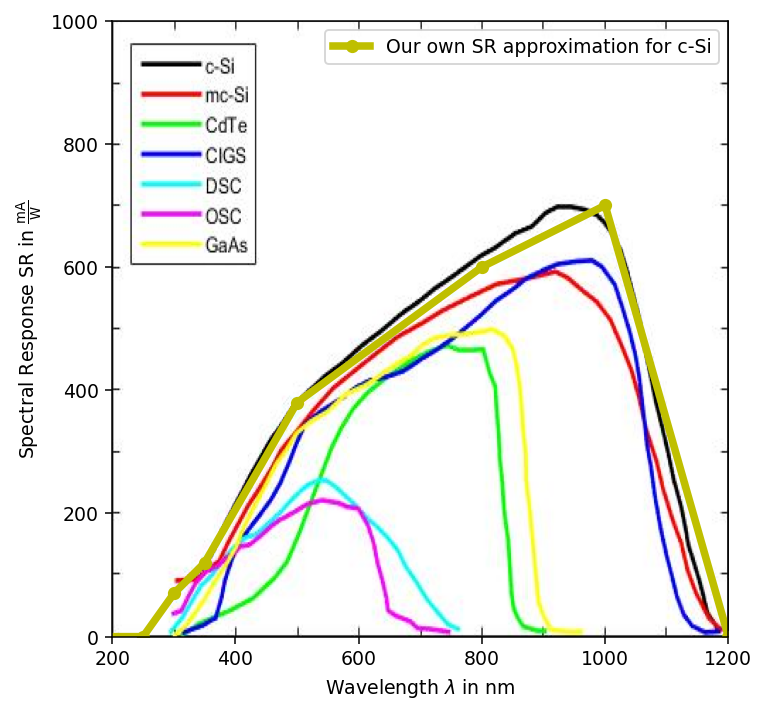

In [43]:
path = r"./images/"
file = r"background.png"
filepath2 = path + file

img = plt.imread(filepath2)

fig, ax = plt.subplots(figsize=(6,6), dpi = 136)

ax.imshow(img, extent = [200, 1200, 0, 1000])
ax.set_xlim(200, 1200)
ax.plot(lam_SR_nm, SR_1000, "yo-", linewidth = 4, label = r"Our own SR approximation for c-Si")
ax.set_xlabel(r"Wavelength $\lambda$ in nm")
ax.set_ylabel(r"Spectral Response SR in $\mathrm{\frac{mA}{W}}$")
ax.legend()
plt.show()

Linear interpolation of the SR curve.

In [44]:
lam_new_nm = np.arange(0, 1500.01, 50)
SR_new = np.interp(lam_new_nm, lam_SR_nm, SR)

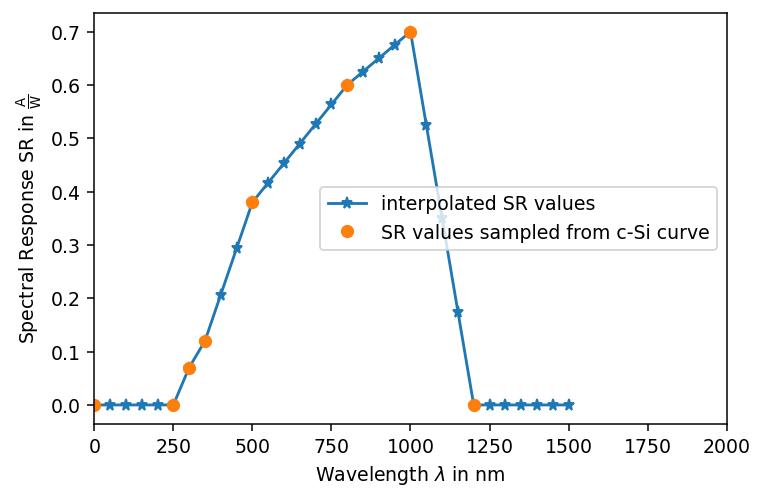

In [45]:
fig2, ax2 = plt.subplots(figsize=(6,4), dpi = 136)
ax2.set_xlabel(r"Wavelength $\lambda$ in nm")
ax2.set_ylabel(r"Spectral Response SR in $\mathrm{\frac{A}{W}}$")
ax2.plot(lam_new_nm, SR_new, "*-", label = "interpolated SR values")
ax2.plot(lam_SR_nm, SR, "o", label = "SR values sampled from c-Si curve")
ax2.legend()
ax2.set_xlim([0, 2000])
plt.show()

### 3.6.3 Determine the total current per squaremeter of a c-Si PV cell

In [46]:
df = pd.read_csv(filepath)

array_w = pd.array(df["Wvlgth nm"])
array_w

mult = array_e * array_w

In [47]:
import numpy as np

In [48]:
np.trapz(mult)

773511.3431590691